In [1]:
import re
import os
import pandas as pd
from sqlalchemy import create_engine
from IPython.display import Image

In [2]:
root = os.path.abspath(os.curdir).replace('\\docs','') # The main directory of project is kept in the variable root. This may have a slice difference in Linux.

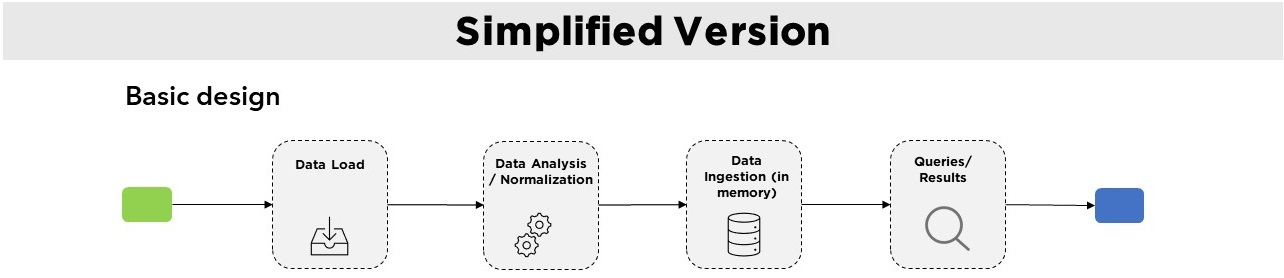

In [3]:
Image(filename=f'{root}/images/simplified_version.jpg')

####  by Abraão Nascimento

## Summary:

__1.__ Data exploration <br>
__2.__ Data ingestion <br>
__3.__ Output 1: Total equipment failures that happened<br>
__4.__ Output 2: Which equipment code had most failures <br>
__5.__ Output 3: Average amount of failures across equipment group, ordered by the number of failures in ascending order<br> 
__6.__ Contact <br> 

In [4]:
root_data = f'{root}\\data\\'

### 1. Data exploration 

In [5]:
equipment_sensors = pd.read_csv(f'{root_data}equipment_sensors.csv', sep=';') # If you are using Linux, replace \\ to /, please.

#### 1.1 Data equipment_sensors.csv

In [6]:
equipment_sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   equipment_id  100 non-null    int64
 1   sensor_id     100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB


In [7]:
equipment_sensors.duplicated().sum()

0

It was possible to check that columns are in integer format, with no null values and no duplicate records.

#### 1.2 Data equipment.json

In [8]:
equipment = pd.read_json(f'{root_data}equipment.json')
equipment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   equipment_id  14 non-null     int64 
 1   code          14 non-null     object
 2   group_name    14 non-null     object
dtypes: int64(1), object(2)
memory usage: 464.0+ bytes


In [9]:
equipment['equipment_id'].duplicated().sum()

0

It was possible to check that columns are integer and string format, and there are no null values and no duplicates in the equipment_id field.

#### 1.2 Data equipment_failure_sensors.log

In [10]:
logs = pd.read_csv(f'{root_data}equipment_failure_sensors.log', sep='\t', header=None)
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36979 entries, 0 to 36978
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       36979 non-null  object
 1   1       36979 non-null  object
 2   2       36979 non-null  object
 3   3       36979 non-null  object
 4   4       36979 non-null  object
 5   5       36979 non-null  object
dtypes: object(6)
memory usage: 1.7+ MB


In [11]:
logs.head()

,0,1,2,3,4,5
0,[2019-12-10 10:46:09],ERROR,sensor[5]:,(temperature,"365.26, vibration",-6305.32)
1,[2019-12-10 10:46:09],ERROR,sensor[43]:,(temperature,"458.47, vibration",-58.41)
2,[2019-12-10 10:46:09],ERROR,sensor[44]:,(temperature,"57.16, vibration",-999.66)
3,[2019-12-10 10:46:09],ERROR,sensor[67]:,(temperature,"106.69, vibration",-4659.02)
4,[2019-12-02 06:53:29],ERROR,sensor[5]:,(temperature,"26.42, vibration",-3438.67)


Fields are not well structured, because of that they will be normalized and structured into 4 columns: datetime, type, message, sensor_id.

##### 1.2.1  Merging and renaming fields

In [12]:
logs.head()

,0,1,2,3,4,5
0,[2019-12-10 10:46:09],ERROR,sensor[5]:,(temperature,"365.26, vibration",-6305.32)
1,[2019-12-10 10:46:09],ERROR,sensor[43]:,(temperature,"458.47, vibration",-58.41)
2,[2019-12-10 10:46:09],ERROR,sensor[44]:,(temperature,"57.16, vibration",-999.66)
3,[2019-12-10 10:46:09],ERROR,sensor[67]:,(temperature,"106.69, vibration",-4659.02)
4,[2019-12-02 06:53:29],ERROR,sensor[5]:,(temperature,"26.42, vibration",-3438.67)


In [13]:
logs['message'] = ''

In [14]:
logs.loc[:]

,0,1,2,3,4,5,message
0,[2019-12-10 10:46:09],ERROR,sensor[5]:,(temperature,"365.26, vibration",-6305.32),
1,[2019-12-10 10:46:09],ERROR,sensor[43]:,(temperature,"458.47, vibration",-58.41),
2,[2019-12-10 10:46:09],ERROR,sensor[44]:,(temperature,"57.16, vibration",-999.66),
3,[2019-12-10 10:46:09],ERROR,sensor[67]:,(temperature,"106.69, vibration",-4659.02),
4,[2019-12-02 06:53:29],ERROR,sensor[5]:,(temperature,"26.42, vibration",-3438.67),
...,...,...,...,...,...,...,...
36974,[2019-12-09 09:26:38],ERROR,sensor[27]:,(temperature,"472.36, vibration",9660.13),
36975,[2019-12-09 09:26:38],ERROR,sensor[51]:,(temperature,"134.64, vibration",-736.71),
36976,[2019-12-09 09:26:38],ERROR,sensor[56]:,(temperature,"388.94, vibration",1237.49),
36977,[2019-12-09 09:26:38],ERROR,sensor[81]:,(temperature,"82.97, vibration",-1871.2),


In [15]:
logs['message'] = logs[2] + ' ' + logs[3] + ' ' + logs[4] + ' ' +  logs[5]
logs.rename(columns = {0:"datetime", 1:"type"}, inplace = True)
logs = logs[["datetime","type","message"]]

##### 1.2.2 Creating a new field for sensor_id

In [16]:
messages = logs.message.tolist()
messages[0:3]

['sensor[5]: (temperature 365.26, vibration -6305.32)',
 'sensor[43]: (temperature 458.47, vibration -58.41)',
 'sensor[44]: (temperature 57.16, vibration -999.66)']

In [17]:
sensor_ids = [re.search('\[(\d+)\]', record).group(0) for record in messages] # Regex and list comprehension are used to find sensor IDs
sensor_ids[0:10]

['[5]', '[43]', '[44]', '[67]', '[5]', '[43]', '[44]', '[67]', '[11]', '[15]']

In [18]:
sensor_ids = [re.search('\d+',ID).group(0) for ID in sensor_ids]
sensor_ids[0:10]

['5', '43', '44', '67', '5', '43', '44', '67', '11', '15']

In [19]:
logs['sensor_id'] = sensor_ids
logs.head()

,datetime,type,message,sensor_id
0,[2019-12-10 10:46:09],ERROR,"sensor[5]: (temperature 365.26, vibration -630...",5
1,[2019-12-10 10:46:09],ERROR,"sensor[43]: (temperature 458.47, vibration -58...",43
2,[2019-12-10 10:46:09],ERROR,"sensor[44]: (temperature 57.16, vibration -999...",44
3,[2019-12-10 10:46:09],ERROR,"sensor[67]: (temperature 106.69, vibration -46...",67
4,[2019-12-02 06:53:29],ERROR,"sensor[5]: (temperature 26.42, vibration -3438...",5


##### 1.2.3 Filtering Data by January, 2020

In [20]:
logs_01_2020 = logs[logs['datetime'].str.contains('2020-01')==True]

### 2 - Data ingestion (In Memory)

Note: The production code ('source code' folder) reads the data on-demand by using a chunk size of 100.000 records each to improve the efficiency of the code when it is dealing with gigabytes-size data.

##### 2.1 Creating a in memory database

In [21]:
in_memory_db = create_engine('sqlite://', echo=False)

##### 2.2 Loading the data to the database created

In [22]:
logs.to_sql('logs', con=in_memory_db)
equipment.to_sql('equipment', con=in_memory_db)
equipment_sensors.to_sql('equipment_sensors', con=in_memory_db)

### 3 - Output 1: Total equipment failures that happened

In [23]:
sql = '''
SELECT COUNT(*) 
FROM (SELECT DISTINCT equipment_id
      FROM logs
      LEFT JOIN equipment_sensors
      ON logs.sensor_id = equipment_sensors.sensor_id 
      WHERE logs.type = 'ERROR')
'''

In [24]:
output = {'Total equipment failures': [in_memory_db.execute(sql).fetchall()[0][0]]}
output = pd.DataFrame(data=output)
output

,Total equipment failures
0,13


### 4 - Output 2: Which equipment code had most failures

In [25]:
sql2 = '''
SELECT code, COUNT(code) AS total FROM (SELECT equipment_id
            FROM logs
            LEFT JOIN equipment_sensors
            ON logs.sensor_id = equipment_sensors.sensor_id 
            WHERE logs.type = 'ERROR') AS query1
LEFT JOIN equipment
ON query1.equipment_id = equipment.equipment_id
GROUP BY code
ORDER BY total DESC
'''
data = in_memory_db.execute(sql2).fetchall()

In [26]:
output2 = {'Equipment code with most failures': [data[0][0]], 'Total of failures': [data[0][1]]}
output2 = pd.DataFrame(data=output2)
output2

,Equipment code with most failures,Total of failures
0,E1AD07D4,3753


### 5 - Output 3: Average amount of failures across equipment group, ordered by the number of failures in ascending order

In [27]:
sql3 = '''
SELECT group_name, CAST(ROUND(AVG(total)) AS INTEGER)
FROM  (SELECT code, COUNT(code) AS total 
       FROM (SELECT equipment_id
       FROM logs
       LEFT JOIN equipment_sensors
       ON logs.sensor_id = equipment_sensors.sensor_id 
       WHERE logs.type = 'ERROR') AS query1
    LEFT JOIN equipment
    ON query1.equipment_id = equipment.equipment_id
    GROUP BY code) AS query2
LEFT JOIN equipment
ON query2.code = equipment.code
GROUP BY group_name
ORDER BY total ASC
'''
data = in_memory_db.execute(sql3).fetchall()

In [28]:
output3 = {'Group_name': [line[0] for line in data ], 'Average': [line[1] for line in data]}
output3 = pd.DataFrame(data=output3)
output3

,Group_name,Average
0,FGHQWR2Q,2704
1,VAPQY59S,2592
2,PA92NCXZ,2727
3,NQWPA8D3,2881
4,9N127Z5P,3034
5,Z9K1SAP4,3699


Average has been formatted to integer, but it also can be decimal if needed

#### 6. Contact

Hi. You can find more information about me by searching on my LinkedIn profile https://www.linkedin.com/in/abra%C3%A3o-nascimento-39915162/. <br> This and other projects can be found on my Github page: https://github.com/abraaonascimento. 

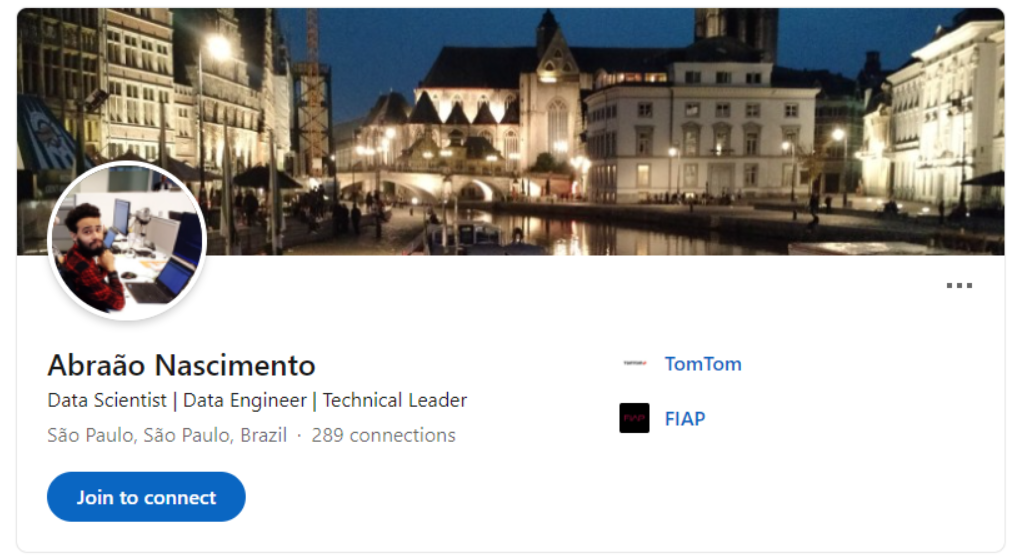

In [29]:
Image(filename=f'{root}/images/contact.jpg')

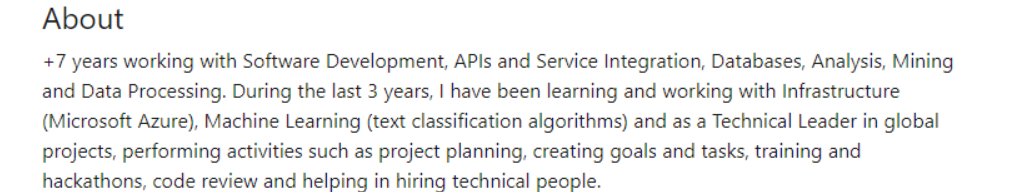

In [30]:
Image(filename=f'{root}/images/about.jpg')

# Thank you!